# Redevelop time operations

This is meant to be a temporary notebook for redesigning time operations around chained pandas methods, the functions and test code should ultimately be ported back to the python modules, unit and integration tests

In [1]:
from datetime import timedelta as td
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from floris.utilities import wrap_180, wrap_360

import utilities as fsut

from scipy.stats import circmean

## Develop a test dataset

Follow Bart's lead and establish a test dataset can confirm that changes to function don't change very much the results of calculations but do help with timing/clarity/memory

In [2]:
N_turbines = 5 # Number of turbines to simulate
N_data_points = 5 * 60 # Number of data points

Text(0.5, 1.0, 'Wind Direction')

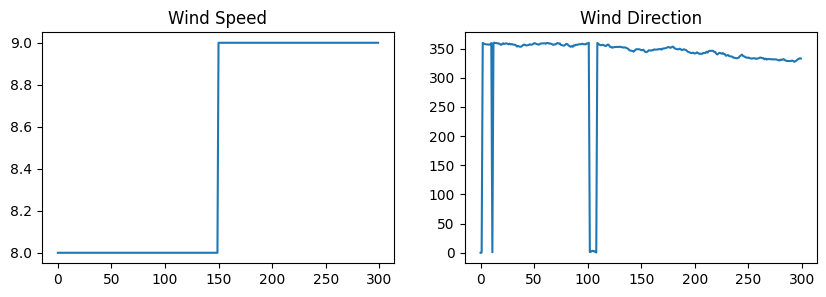

In [3]:
# Generate a fake ws/wd history

# Fake 1Hz time index
time = pd.to_datetime(pd.date_range(datetime.datetime.today(), periods=N_data_points, freq='1S').tolist())

# Wind Speed
windspeeds = [8., 9.] # Just do a step change in wind in the simulation
ws = np.ones(N_data_points) * windspeeds[0]
ws[int(N_data_points/2):] = windspeeds[1]

# Wind Direction
# Make wind direction a random walk around 0 to provide some wrap testing
wd = np.zeros_like(ws)
for i in range(1,N_data_points):
    wd[i] = wd[i-1] + np.random.randn()
wd = wrap_360(wd)    

fig, axarr = plt.subplots(1,2,figsize=(10,3))
axarr[0].plot(ws)
axarr[0].set_title('Wind Speed')
axarr[1].plot(wd) 
axarr[1].set_title('Wind Direction')

In [9]:
# Now build up dataframes

df = pd.DataFrame({'time':time})

for t in range(N_turbines):
    t_name = '%03d' % t # Turbine number
    
    ws_t = ws + np.random.randn(len(ws))
    wd_t = wrap_360(wd + np.random.randn(len(wd)))
    
    # Now make turbine histories assuming turbines dont yaw and simple power rule
    yaw_t = np.zeros_like(wd_t)
    vane_t = wrap_180(wd_t - yaw_t)
    pow_t = ws_t ** 3
    
    df = (df
        .assign(**{'ws_%s' % t_name: ws_t})
        .assign(**{'wd_%s' % t_name: wd_t})   
        .assign(**{'yaw_%s' % t_name: yaw_t})   
        .assign(**{'vane_%s' % t_name: vane_t})   
        .assign(**{'pow_%s' % t_name: pow_t})   
    )
df.head()
    

,time,ws_000,wd_000,yaw_000,vane_000,pow_000,ws_001,wd_001,yaw_001,vane_001,...,ws_003,wd_003,yaw_003,vane_003,pow_003,ws_004,wd_004,yaw_004,vane_004,pow_004
0,2022-09-23 14:48:45.974660,7.428118,0.565194,0.0,0.565194,409.860722,8.135061,358.249970,0.0,-1.750030,...,7.918730,359.026417,0.0,-0.973583,496.554159,7.015466,1.124011,0.0,1.124011,345.278540
1,2022-09-23 14:48:46.974660,7.283807,0.661536,0.0,0.661536,386.433978,6.670342,0.789173,0.0,0.789173,...,7.776261,1.577302,0.0,1.577302,470.232364,8.538736,358.628445,0.0,-1.371555,622.559391
2,2022-09-23 14:48:47.974660,8.290629,359.430315,0.0,-0.569685,569.852385,8.924932,359.618297,0.0,-0.381703,...,8.378972,359.157069,0.0,-0.842931,588.263849,8.274836,0.028747,0.0,0.028747,566.602191
3,2022-09-23 14:48:48.974660,7.731795,358.770285,0.0,-1.229715,462.211762,7.840916,359.455109,0.0,-0.544891,...,7.353571,359.817593,0.0,-0.182407,397.644454,8.026807,0.160033,0.0,0.160033,517.164170
4,2022-09-23 14:48:49.974660,7.992041,357.437456,0.0,-2.562544,510.473302,7.735396,356.755501,0.0,-3.244499,...,8.350750,356.542766,0.0,-3.457234,582.339816,8.004940,357.309338,0.0,-2.690662,512.949071


In [10]:
# Get a list of angular columns
cols_angular = [c for c in df.columns if (('wd' in c) or ('yaw' in c))]
cols_angular

['wd_000',
 'yaw_000',
 'wd_001',
 'yaw_001',
 'wd_002',
 'yaw_002',
 'wd_003',
 'yaw_003',
 'wd_004',
 'yaw_004']

## Make faster wrapping functions that won't need calls to apply

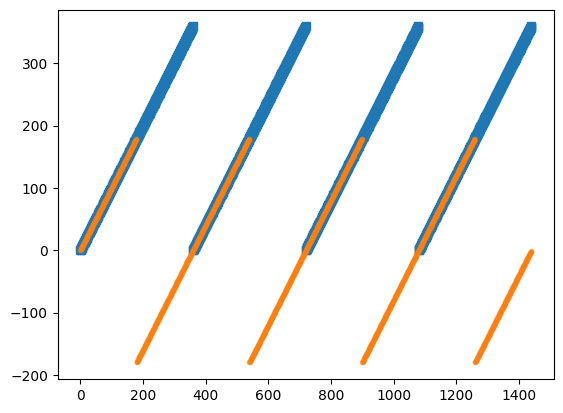

In [4]:
# Design faster wrapping functions
x = np.arange(-720,720,1)
y_0_360 = x % 360  # 360 wrap
y_180 = ( (x + 180) % 360) - 180 # 180 wrap

fig, ax = plt.subplots()
ax.plot(y_0_360,'s',ls='None')
ax.plot(y_180,'.',ls='None',alpha=0.5)

#### Timing of wrapping

In [5]:
%%timeit
wrap_360(x)

12.9 µs ± 70.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [6]:
%%timeit
x % 360  # 360 wrap

3.75 µs ± 17.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [7]:
%%timeit
wrap_180(x)

12.9 µs ± 95.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
%%timeit
( (x + 180) % 360) - 180

6.81 µs ± 16.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Moving average analysis (current version)

In [11]:
def df_movingaverage(
    df_in,
    cols_angular,
    window_width=td(seconds=60),
    min_periods=1,
    center=True,
    calc_median_min_max_std=False,
    return_index_mapping=False,
):

    # Copy and ensure dataframe is indexed by time
    df = df_in.copy()
    if "time" in df.columns:
        df = df.set_index("time")

    # Find non-angular columns
    if isinstance(cols_angular, bool):
        if cols_angular:
            cols_angular = [c for c in df.columns]
        else:
            cols_angular = []
    cols_regular = [c for c in df.columns if c not in cols_angular]

    # Now calculate cos and sin components for angular columns
    sin_cols = ["{:s}_sin".format(c) for c in cols_angular]
    cos_cols = ["{:s}_cos".format(c) for c in cols_angular]
    df[sin_cols] = np.sin(df[cols_angular] * np.pi / 180.0)
    df[cos_cols] = np.cos(df[cols_angular] * np.pi / 180.0)

    # Drop angular columns
    df = df.drop(columns=cols_angular)

    # Now calculate rolling (moving) average
    df_roll = df.rolling(
        window_width,
        center=center,
        axis=0,
        min_periods=min_periods
    )

    # First calculate mean values of non-angular columns
    df_ma = df_roll[cols_regular].mean().copy()

    # Now add mean values of angular columns
    df_ma[cols_angular] = wrap_360(
        np.arctan2(
            df_roll[sin_cols].mean().values,
            df_roll[cos_cols].mean().values
        ) * 180.0 / np.pi
    )

    # Figure out which indices/data points belong to each window
    if (return_index_mapping or calc_median_min_max_std):
        # Use next for loops to determine starting and inding indices for 
        # window operations. Avoids pandas version issues for rolling(). 
        # May be slow for large datasets.
        timestamps = df_ma.index.to_list()
        windows_min = [np.where([t2 >= t - window_width/2 \
                                for t2 in timestamps])[0][0]
                       for t in timestamps]
        windows_max = [np.where([t2 < t + window_width/2 \
                                for t2 in timestamps])[0][-1]
                       for t in timestamps]

        # Now create a large array that contains the array of indices, with
        # the values in each row corresponding to the indices upon which that
        # row's moving/rolling average is based. Note that we purposely create
        # a larger matrix than necessary, since some rows/windows rely on more
        # data (indices) than others. This is the case e.g., at the start of
        # the dataset, at the end, and when there are gaps in the data. We fill
        # the remaining matrix entries with "-1".
        dn = int(np.ceil(window_width/fsut.estimate_dt(df_in["time"]))) + 5
        data_indices = -1 * np.ones((df_ma.shape[0], dn), dtype=int)
        for ii in range(len(windows_min)):
            lb = windows_min[ii]
            ub = windows_max[ii]
            ind = np.arange(lb, ub + 1, dtype=int)
            data_indices[ii, ind - lb] = ind

    # Calculate median, min, max, std if necessary
    if calc_median_min_max_std:
        # Append all current columns with "_mean"
        df_ma.columns = ["{:s}_mean".format(c) for c in df_ma.columns]

        # Add statistics for regular columns
        funs = ["median", "min", "max", "std"]
        cols_reg_stats = ["_".join(i) for i in product(cols_regular, funs)]
        df_ma[cols_reg_stats] = df_roll[cols_regular].agg(funs).copy()

        # Add statistics for angular columns
        # Firstly, create matrix with indices for the mean values
        data_indices_mean = np.tile(np.arange(0, df_ma.shape[0]), (dn, 1)).T

        # Grab raw and mean data and format as numpy arrays
        D = df_in[cols_angular].values
        M = df_ma[["{:s}_mean".format(c) for c in cols_angular]].values

        # Add NaN row as last row. This corresponds to the -1 indices
        # that we use as placeholders. This way, those indices do not
        # count towards the final statistics (median, min, max, std).
        D = np.vstack([D, np.nan * np.ones(D.shape[1])])
        M = np.vstack([M, np.nan * np.ones(M.shape[1])])

        # Now create a 3D matrix containing all values. The three dimensions
        # come from:
        #  > [0] one dimension containing the rolling windows,
        #  > [1] one with the raw data underlying each rolling window,
        #  > [2] one for each angular column within the dataset
        values = D[data_indices, :]
        values_mean = M[data_indices_mean, :]

        # Center values around values_mean
        values[values > (values_mean + 180.0)] += -360.0
        values[values < (values_mean - 180.0)] += 360.0

        # Calculate statistical properties and wrap to [0, 360)
        values_median = wrap_360(np.nanmedian(values, axis=1))
        values_min = wrap_360(np.nanmin(values, axis=1))
        values_max = wrap_360(np.nanmax(values, axis=1))
        values_std = wrap_360(np.nanstd(values, axis=1))

        # Save to dataframe
        df_ma[["{:s}_median".format(c) for c in cols_angular]] = values_median
        df_ma[["{:s}_min".format(c) for c in cols_angular]] = values_min
        df_ma[["{:s}_max".format(c) for c in cols_angular]] = values_max
        df_ma[["{:s}_std".format(c) for c in cols_angular]] = values_std

    if return_index_mapping:
        return df_ma, data_indices

    return df_ma


## New Version

#### Helper functions

In [12]:
# # def mean_ang(x):
# #     return circmean(x, 0., 360.)

# def df_angles(df):
    
#     return np.arctan2(np.mean(np.sin(df )), np.mean(np.cos(df * np.pi / 180.0))) * 180. / np.pi

# def mean_ang(x):

#     return np.arctan2(np.mean(np.sin(x * np.pi / 180.0)), np.mean(np.cos(x * np.pi / 180.0))) * 180. / np.pi

# def std_ang(x):
    
#     # Move the mean to 0 and wrap to 180 prior to std
#     return np.nanstd(wrap_180(x - mean_ang(x)))

# def median_ang(x):
#     # Move the mean to 0 and wrap to 180 prior to std
#     return wrap_360(np.nanmedian(wrap_180(x - mean_ang(x))) + mean_ang(x))

# def max_ang(x):
#     # Move the mean to 0 and wrap to 180 prior to std
#     return wrap_360(np.nanmax(wrap_180(x - mean_ang(x))) + mean_ang(x))

# def min_ang(x):
#     # Move the mean to 0 and wrap to 180 prior to std
#     return wrap_360(np.nanmin(wrap_180(x - mean_ang(x))) + mean_ang(x))



In [13]:
# Function from "EFFECTIVE PANDAS" for flattening multi-level column names
def flatten_cols (df):
    cols = ['_'. join(map(str , vals ))
    for vals in df.columns.to_flat_index ()]
    df.columns = cols
    return df

In [14]:
def df_movingaverage_new(
    df_in,
    cols_angular,
    window_width=td(seconds=60),
    min_periods=1,
    center=True,
    calc_median_min_max_std=False,
    return_index_mapping=False,
):
    
    df = df_in.set_index('time').copy()
    
    # Find non-angular columns
    if isinstance(cols_angular, bool):
        if cols_angular:
            cols_angular = [c for c in df.columns]
        else:
            cols_angular = []
    cols_regular = [c for c in df.columns if c not in cols_angular]
    
    # Save the full columns
    full_columns = df.columns
    
    # Carry out the mean calculations
        
    df_regular = (df
                     #.set_index('time') # Set index to time
                     [cols_regular] # Select only non-angular columns
                     .rolling(window_width,
                        center=center,
                        axis=0,
                        min_periods=min_periods)
                     .mean()
                 )


    df_cos = (df
                     #.set_index('time') # Set index to time
                     [cols_angular] # Select only non-angular columns
                     .pipe(lambda df_: np.cos(df_ * np.pi / 180.))
                     .rolling(window_width,
                        center=center,
                        axis=0,
                        min_periods=min_periods)
                     .mean()
                 )

    df_sin = (df
                     #.set_index('time') # Set index to time
                     [cols_angular] # Select only non-angular columns
                     .pipe(lambda df_: np.sin(df_ * np.pi / 180.))
                     .rolling(window_width,
                        center=center,
                        axis=0,
                        min_periods=min_periods)
                     .mean()
                 )
    
    dfm =  (df_regular
                .join((np.arctan2(df_sin,df_cos) * 180. / np.pi) % 360)
                [full_columns] # put back in order

    )
    
    if not calc_median_min_max_std:
        
        return dfm
    
    
    
    if calc_median_min_max_std: # if including other statistics
        

        
   
        df_regular_stats = (df
                         # [cols_regular] # Select only non-angular columns
                         .rolling(window_width,
                            center=center,
                            axis=0,
                            min_periods=min_periods)
                         .agg(["median", "min", "max", "std"])
                         .pipe(lambda df_: flatten_cols(df_))
                     )
            
        # Build up a dataframe of fixed means to offset the std calculations by
        
        df_cos = (df
                         [cols_angular] # Select only non-angular columns
                         .pipe(lambda df_: np.cos(df_ * np.pi / 180.))
                         .resample(window_width)
                         .transform('mean') # Map back to original index
                     )

        df_sin = (df
                         [cols_angular] # Select only non-angular columns
                         .pipe(lambda df_: np.sin(df_ * np.pi / 180.))
                         .resample(window_width)
                         .transform('mean') # Map back to original index
                     )

        df_fixed_means =  (np.arctan2(df_sin,df_cos) * 180. / np.pi) % 360

        
        
        
        # Redo the std just for angular functions
        df_angular_std = (df
                         .subtract(df_fixed_means) # Subtract the fixed mean values
                         [cols_angular] # Select only non-angular columns
                         .add(180) # Shift up by 180 (start of sequence for -180/180 wrap)
                         .mod(360) # Now wrap by 360
                         .subtract(180)
                         .rolling(window_width,
                            center=center,
                            axis=0,
                            min_periods=min_periods)
                         .std()# .agg(std_ang)
                         .rename({c: c + '_std' for c in dfm.columns},axis='columns')

                     )   
        # Merge the stats
        df_stats = (df_regular_stats
                                [[c for c in df_regular_stats.columns if c not in df_angular_std.columns]]
                                .join(df_angular_std)
                                # .merge(df_angular_std, how='outer', left_index=True, right_index=True)
                           )
        
        
        # Now merge in means and return
        return (dfm
                    .rename({c: c + '_mean' for c in dfm.columns},axis='columns')
                    .join(df_stats)
                    
               )

## Compare the timing of the operations

### Mean only comparison

#### Previous

In [15]:
%%timeit
df_movingaverage(
    df_in=df,
    cols_angular=cols_angular,
    window_width=td(seconds=60),
    min_periods=1,
    center=True,
    calc_median_min_max_std=False,
    return_index_mapping=False,
)

8.13 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### New

In [16]:
%%timeit
df_movingaverage_new(
    df_in=df,
    cols_angular=cols_angular,
    window_width=td(seconds=60),
    min_periods=1,
    center=True,
    calc_median_min_max_std=False,
    return_index_mapping=False,
)

3 ms ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### With Stats

#### Previous

In [17]:
%%timeit
df_movingaverage(
    df_in=df,
    cols_angular=cols_angular,
    window_width=td(seconds=60),
    min_periods=1,
    center=True,
    calc_median_min_max_std=True,
    return_index_mapping=True,
)


440 ms ± 2.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### New

In [18]:
%%timeit
df_movingaverage_new(
    df_in=df,
    cols_angular=cols_angular,
    window_width=td(seconds=60),
    min_periods=1,
    center=True,
    calc_median_min_max_std=True,
    return_index_mapping=True,
)

34.1 ms ± 411 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Grab all the results

In [19]:
df_previous_mean_only = df_movingaverage(
    df_in=df,
    cols_angular=cols_angular,
    window_width=td(seconds=60),
    min_periods=1,
    center=True,
    calc_median_min_max_std=False,
    return_index_mapping=False,
)

In [20]:
df_previous_stats, data_indices = df_movingaverage(
    df_in=df,
    cols_angular=cols_angular,
    window_width=td(seconds=60),
    min_periods=1,
    center=True,
    calc_median_min_max_std=True,
    return_index_mapping=True,
)


In [21]:
df_new_mean_only = df_movingaverage_new(
    df_in=df,
    cols_angular=cols_angular,
    window_width=td(seconds=60),
    min_periods=1,
    center=True,
    calc_median_min_max_std=False,
    return_index_mapping=False,
)

In [22]:
df_new_stats = df_movingaverage_new(
    df_in=df,
    cols_angular=cols_angular,
    window_width=td(seconds=60),
    min_periods=1,
    center=True,
    calc_median_min_max_std=True,
    return_index_mapping=True,
)

## Compare match

## Mean only

In [24]:
# Same columns
sorted(df_previous_mean_only.columns) == sorted(df_new_mean_only.columns)

True

In [25]:
# How different are the results
df_previous_mean_only.reindex(sorted(df_previous_mean_only.columns), axis=1).subtract(df_new_mean_only.reindex(sorted(df_new_mean_only.columns), axis=1)).abs().max()

pow_000     0.0
pow_001     0.0
pow_002     0.0
pow_003     0.0
pow_004     0.0
vane_000    0.0
vane_001    0.0
vane_002    0.0
vane_003    0.0
vane_004    0.0
wd_000      0.0
wd_001      0.0
wd_002      0.0
wd_003      0.0
wd_004      0.0
ws_000      0.0
ws_001      0.0
ws_002      0.0
ws_003      0.0
ws_004      0.0
yaw_000     0.0
yaw_001     0.0
yaw_002     0.0
yaw_003     0.0
yaw_004     0.0
dtype: float64

## With stats

In [26]:
# Same columns
sorted(df_previous_stats.columns) == sorted(df_new_stats.columns)

True

In [27]:
# How different are the results
# For space compare just 1 turbine
df_p_sub = df_previous_stats[[c for c in df_previous_stats if '000' in c]]
df_n_sub = df_new_stats[[c for c in df_new_stats if '000' in c]]

df_p_sub.reindex(sorted(df_p_sub.columns), axis=1).subtract(df_n_sub.reindex(sorted(df_n_sub.columns), axis=1)).abs().median()

pow_000_max        0.000000
pow_000_mean       0.000000
pow_000_median     0.000000
pow_000_min        0.000000
pow_000_std        0.000000
vane_000_max       0.000000
vane_000_mean      0.000000
vane_000_median    0.000000
vane_000_min       0.000000
vane_000_std       0.000000
wd_000_max         1.016761
wd_000_mean        0.000000
wd_000_median      0.229228
wd_000_min         0.722223
wd_000_std         0.189113
ws_000_max         0.000000
ws_000_mean        0.000000
ws_000_median      0.000000
ws_000_min         0.000000
ws_000_std         0.000000
yaw_000_max        0.000000
yaw_000_mean       0.000000
yaw_000_median     0.000000
yaw_000_min        0.000000
yaw_000_std        0.000000
dtype: float64

<AxesSubplot:>

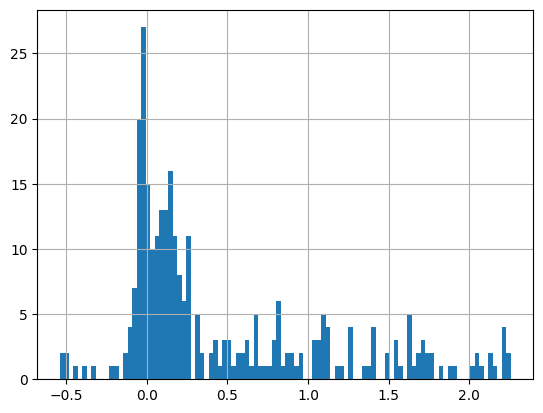

In [28]:
# How important is the error
df_p_sub.subtract(df_n_sub)['wd_000_std'].hist(bins=100)